In [1]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os


Mounted at /content/drive


In [2]:
# Define the dataset path and speaker file names
dataset_path = "/content/drive/MyDrive/Train/combined_files"
speakers = ["Praveen", "Abhi", "Teja"]
audio_files = {speaker: os.path.join(dataset_path, f"{speaker}.wav") for speaker in speakers}

# Duration definitions in seconds
train_duration = 60       # first 1 minute for training
test_start = 60           # 61st second (0-indexed: 60 sec mark)
test_duration = 20        # next 20 seconds for testing

# Function to load training and testing segments from a given audio file
def load_audio_segments(file_path, sr=22050):
    # Load full audio file (if you want to work with default sampling rate)
    y, sr = librosa.load(file_path, sr=sr)
    # Calculate sample indices for training and testing segments
    train_samples = int(train_duration * sr)
    test_start_sample = int(test_start * sr)
    test_samples = int(test_duration * sr)

    # Extract training and testing segments
    y_train = y[:train_samples]
    y_test = y[test_start_sample:test_start_sample + test_samples]
    return y_train, y_test, sr

# Load segments for each speaker and store in dictionaries
train_data = {}
test_data = {}

for speaker, file_path in audio_files.items():
    y_train, y_test, sr = load_audio_segments(file_path)
    train_data[speaker] = (y_train, sr)
    test_data[speaker] = (y_test, sr)

    print(f"{speaker}: Training segment length = {len(y_train)/sr:.2f} sec, Testing segment length = {len(y_test)/sr:.2f} sec")


Praveen: Training segment length = 60.00 sec, Testing segment length = 20.00 sec


<ipython-input-2-4a0f0de9c257>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Abhi: Training segment length = 60.00 sec, Testing segment length = 20.00 sec
Teja: Training segment length = 60.00 sec, Testing segment length = 20.00 sec


In [3]:
# Function to extract MFCC features
def extract_mfcc(y, sr, n_mfcc=13):
    # Compute MFCC features from the audio signal
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

# Extract MFCC features for training and testing data
mfcc_train = {}
mfcc_test = {}

for speaker in speakers:
    y_train, sr = train_data[speaker]
    y_test, _ = test_data[speaker]

    mfcc_train[speaker] = extract_mfcc(y_train, sr)
    mfcc_test[speaker] = extract_mfcc(y_test, sr)

    print(f"{speaker}: MFCC training shape = {mfcc_train[speaker].shape}, MFCC testing shape = {mfcc_test[speaker].shape}")


Praveen: MFCC training shape = (13, 2584), MFCC testing shape = (13, 862)
Abhi: MFCC training shape = (13, 2584), MFCC testing shape = (13, 862)
Teja: MFCC training shape = (13, 2584), MFCC testing shape = (13, 862)


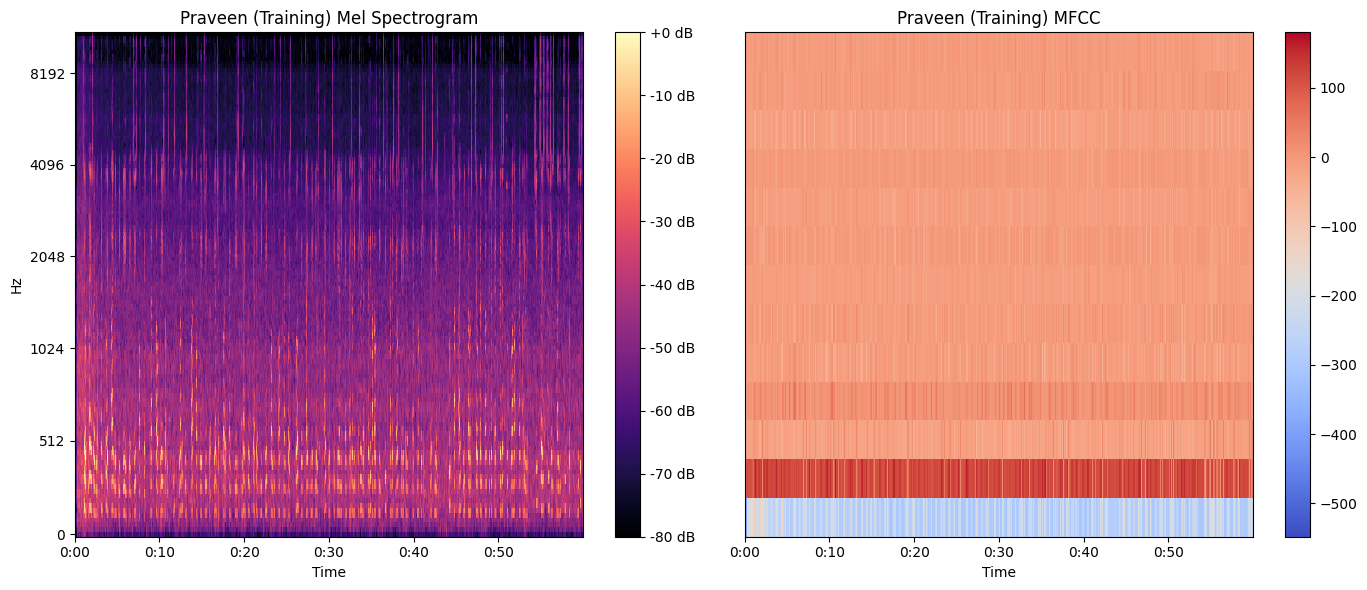

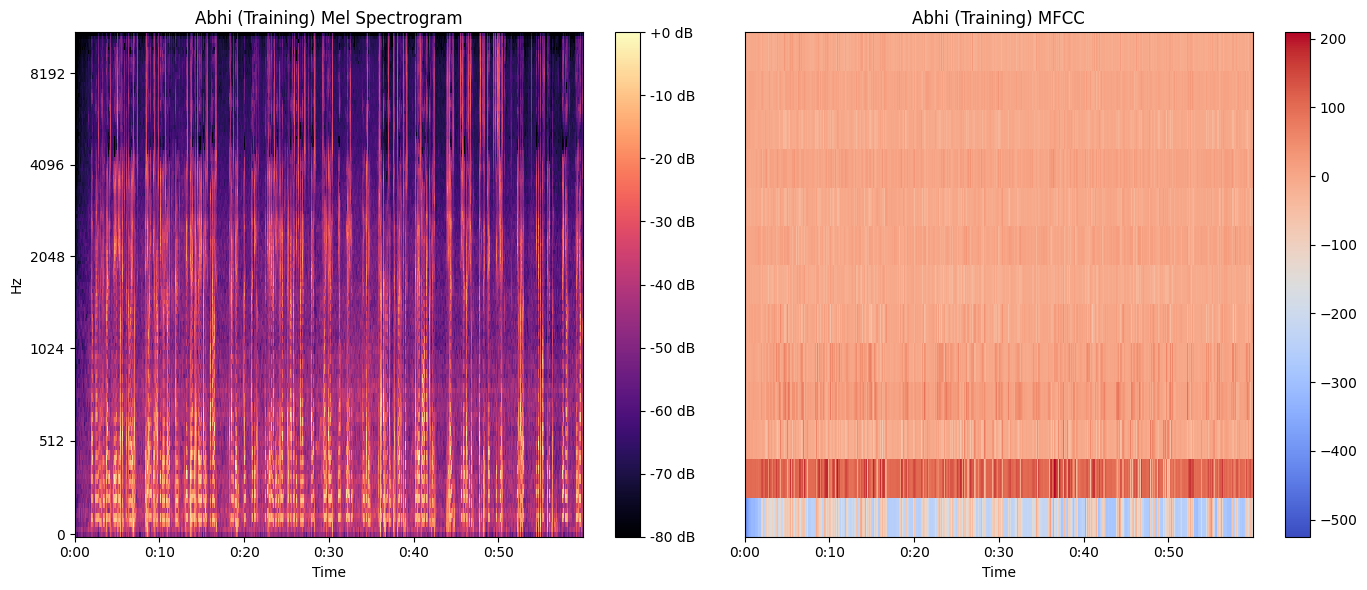

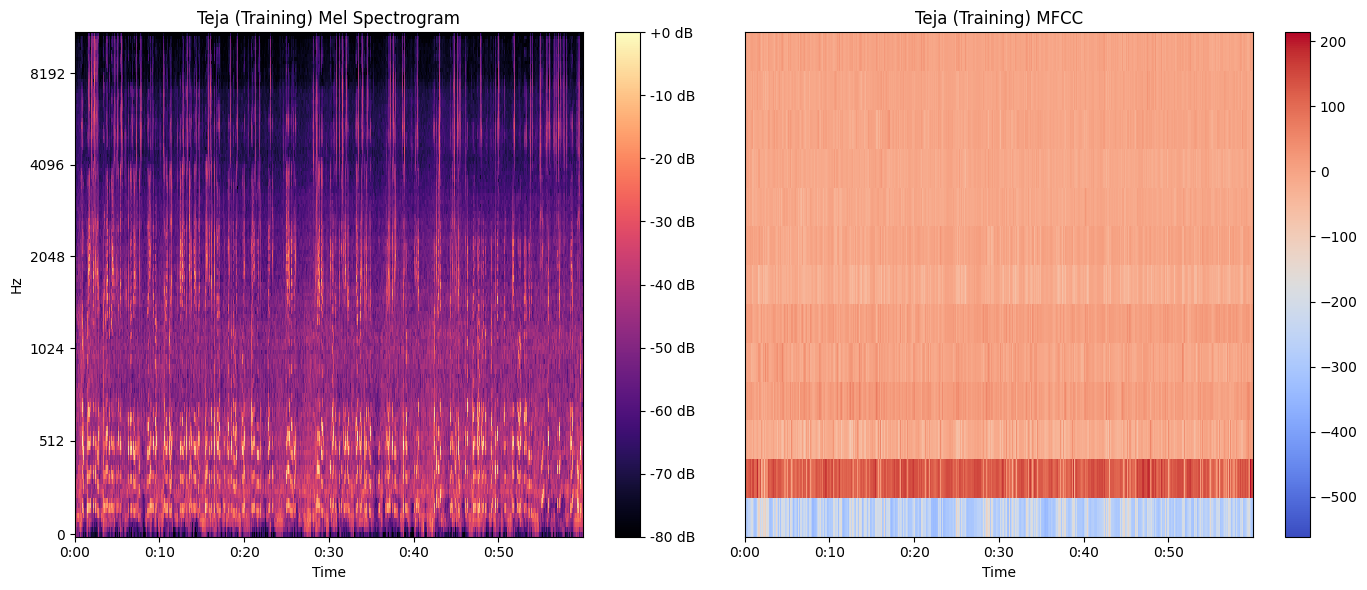

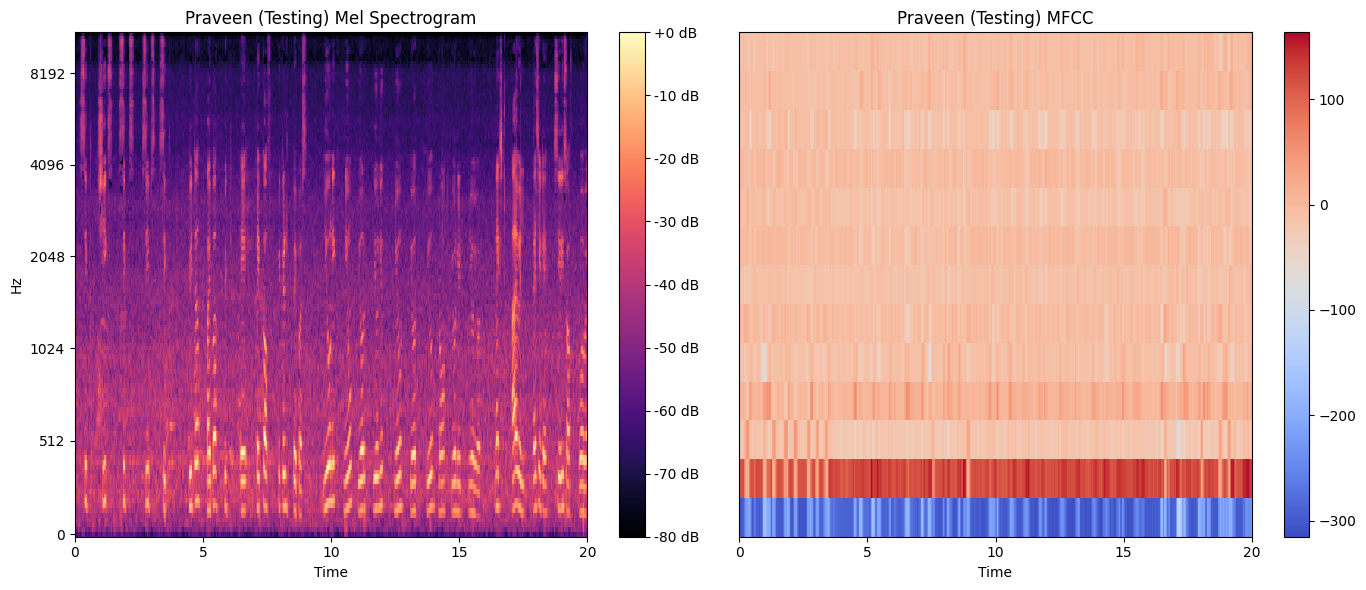

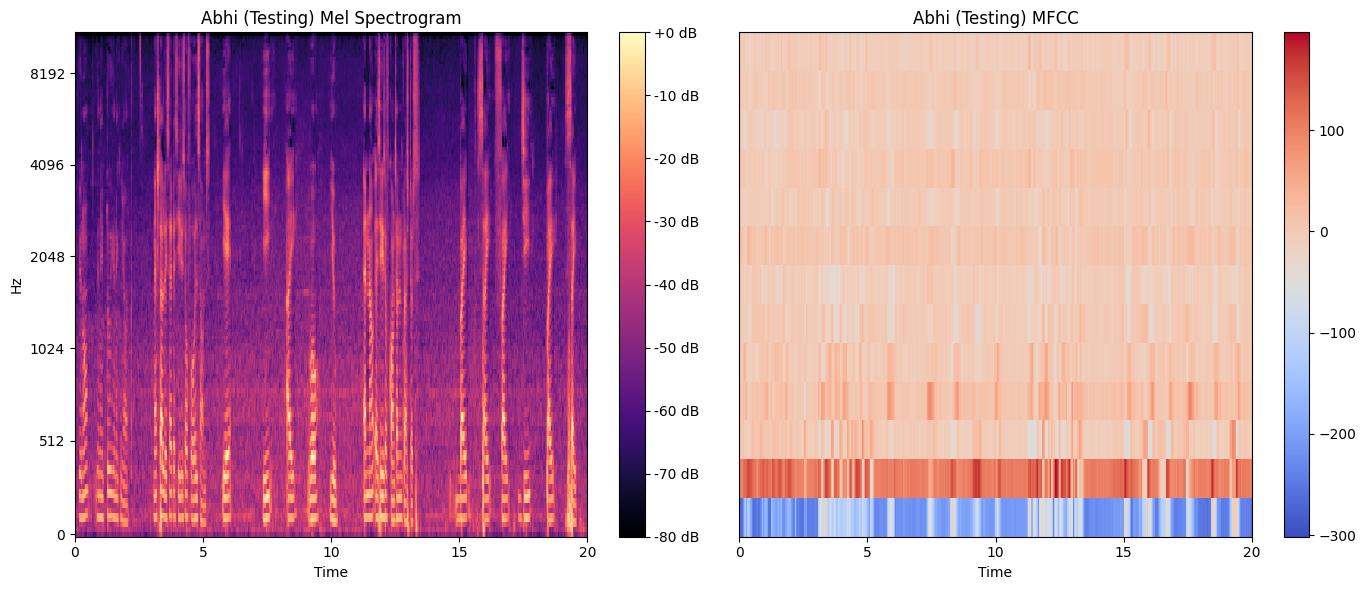

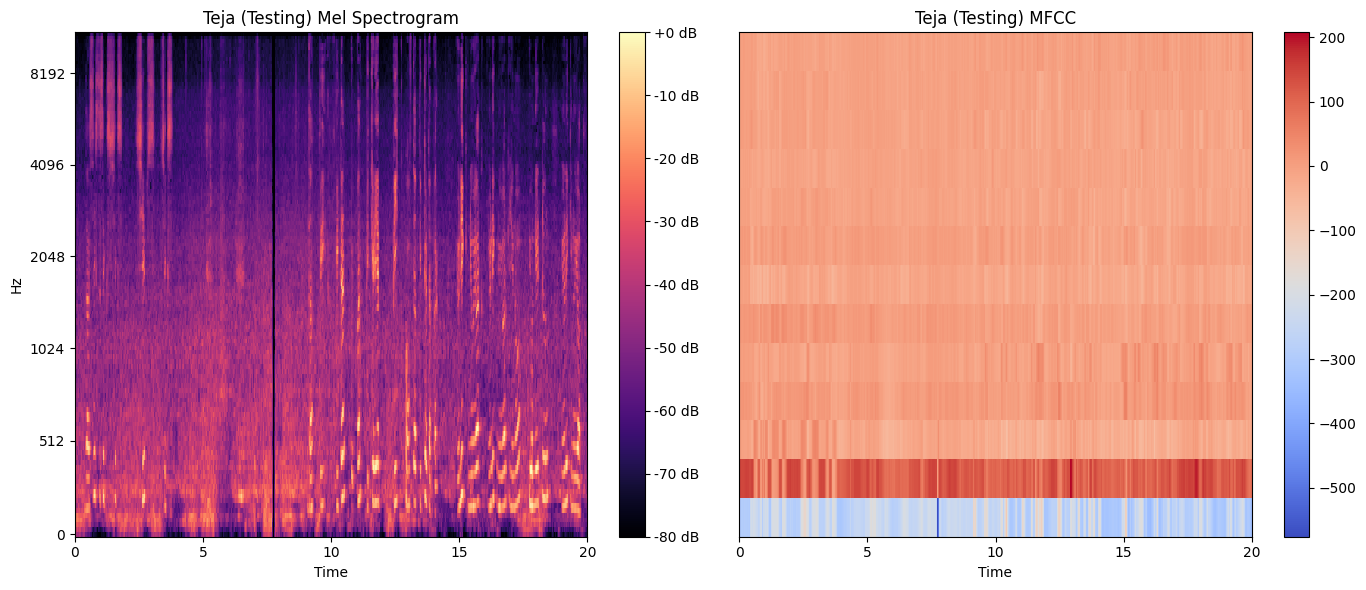

In [4]:
def plot_audio_features(y, sr, title_prefix=""):
    # Create a figure with two subplots: one for the spectrogram and one for MFCCs
    plt.figure(figsize=(14, 6))

    # Plot the spectrogram (log-scaled mel spectrogram)
    plt.subplot(1, 2, 1)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title_prefix} Mel Spectrogram")

    # Plot the MFCCs
    plt.subplot(1, 2, 2)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title(f"{title_prefix} MFCC")

    plt.tight_layout()
    plt.show()

# Plot for training data of each speaker
for speaker in speakers:
    y_train, sr = train_data[speaker]
    plot_audio_features(y_train, sr, title_prefix=f"{speaker} (Training)")

# Plot for testing data of each speaker
for speaker in speakers:
    y_test, sr = test_data[speaker]
    plot_audio_features(y_test, sr, title_prefix=f"{speaker} (Testing)")


In [5]:
# Example: Preparing data for model training (flatten or aggregate features as needed)
# Here, we simply show how you might begin processing your features.

# This example aggregates training MFCC features into a list.
X_train = []
y_train_labels = []
for speaker in speakers:
    features = mfcc_train[speaker]
    # Transpose to have frames as samples
    features = features.T
    X_train.append(features)
    y_train_labels.extend([speaker] * features.shape[0])

X_train = np.concatenate(X_train, axis=0)
print("Aggregated training feature shape:", X_train.shape)


Aggregated training feature shape: (7752, 13)


Confusion Matrix:
[[793  22  47]
 [ 16 811  35]
 [112  54 696]]


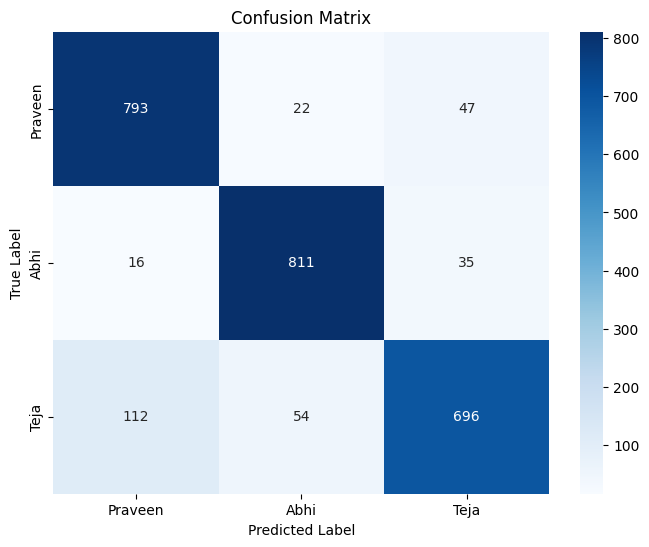

Classification Report:
              precision    recall  f1-score   support

     Praveen       0.91      0.94      0.93       862
        Abhi       0.86      0.92      0.89       862
        Teja       0.89      0.81      0.85       862

    accuracy                           0.89      2586
   macro avg       0.89      0.89      0.89      2586
weighted avg       0.89      0.89      0.89      2586



In [6]:
# Import necessary libraries for classification and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Prepare training data: aggregate MFCC features (transposed to have frames as samples)
X_train = []
y_train_labels = []
for speaker in speakers:
    features = mfcc_train[speaker].T  # Each row is a sample (frame)
    X_train.append(features)
    y_train_labels.extend([speaker] * features.shape[0])
X_train = np.concatenate(X_train, axis=0)

# Prepare testing data similarly
X_test = []
y_test_labels = []
for speaker in speakers:
    features = mfcc_test[speaker].T  # Each row is a sample (frame)
    X_test.append(features)
    y_test_labels.extend([speaker] * features.shape[0])
X_test = np.concatenate(X_test, axis=0)

# Train a logistic regression classifier (you can also try other classifiers)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train_labels)

# Predict speaker labels on the test data
y_pred = clf.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred, labels=speakers)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=speakers, yticklabels=speakers)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Optionally, print a detailed classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred, target_names=speakers))


In [7]:
# Calculate individual speaker accuracies from the confusion matrix
speaker_accuracies = {}
for i, speaker in enumerate(speakers):
    true_positive = cm[i, i]
    total_samples = cm[i, :].sum()
    accuracy = true_positive / total_samples if total_samples > 0 else 0
    speaker_accuracies[speaker] = accuracy
    print(f"Accuracy for {speaker}: {accuracy*100:.2f}%")

Accuracy for Praveen: 92.00%
Accuracy for Abhi: 94.08%
Accuracy for Teja: 80.74%


In [8]:
# Define the new audio file path and (optionally) its known speaker label.
new_audio_path = "/content/drive/MyDrive/Extra.wav"
# Set the ground truth label if known; if unknown, leave as None.
ground_truth = "Abhi"  # Change to the correct label if available, or set to None

# Load the new audio file; here we load the entire file (or you can specify a segment if desired).
y_extra, sr_extra = librosa.load(new_audio_path, sr=22050)
print(f"Loaded extra audio: {new_audio_path}, Duration: {len(y_extra)/sr_extra:.2f} sec")

# Extract MFCC features for the new audio file.
mfcc_extra = librosa.feature.mfcc(y=y_extra, sr=sr_extra, n_mfcc=13)
# Transpose so that each row is a feature vector corresponding to a frame.
X_extra = mfcc_extra.T

# Set a confidence threshold; frames with max probability below this threshold will be labeled as 'Unauthorised'
confidence_threshold = 0.5

# Get prediction probabilities for each frame
probs = clf.predict_proba(X_extra)
# Get the predicted labels for each frame (this gives labels from the trained classes)
predicted_labels = clf.classes_[np.argmax(probs, axis=1)]
# Determine the maximum probability for each frame
max_probs = np.max(probs, axis=1)

# For each frame, if the maximum probability is below the threshold, override the prediction to 'Unauthorised'
final_frame_labels = []
for label, conf in zip(predicted_labels, max_probs):
    if conf < confidence_threshold:
        final_frame_labels.append("Unauthorised")
    else:
        final_frame_labels.append(label)

# Compute majority vote over all frames
from collections import Counter
vote_count = Counter(final_frame_labels)
majority_label, count = vote_count.most_common(1)[0]

# Display the predicted speaker
if majority_label == "Unauthorised":
    print("Predicted Speaker: Unauthorised speaker")
else:
    print(f"Predicted Speaker: {majority_label}")

# If a ground truth label is provided, calculate frame-level and overall accuracy.
if ground_truth is not None:
    # Frame-level accuracy: compare each frame's prediction with the ground truth.
    # Note: if a frame is marked 'Unauthorised', it is counted as incorrect.
    frame_accuracy = np.mean(np.array(final_frame_labels) == ground_truth)
    print(f"Frame-level Accuracy for {ground_truth}: {frame_accuracy*100:.2f}%")

    # Overall prediction accuracy: 100% if the majority vote matches ground truth; otherwise 0%.
    overall_accuracy = 100.0 if majority_label == ground_truth else 0.0
    print(f"Overall Prediction Accuracy: {overall_accuracy:.2f}%")
else:
    print("Ground truth label not provided; only predicted speaker is displayed.")

Loaded extra audio: /content/drive/MyDrive/Extra.wav, Duration: 60.91 sec
Predicted Speaker: Praveen
Frame-level Accuracy for Abhi: 1.49%
Overall Prediction Accuracy: 0.00%
